In [ ]:
%pip install scikit-learn seaborn dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

In [ ]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# data = pd.read_csv('./bot.csv')
import pandas as pd
from glob import glob

# 读取所有 Full5pc 的 CSV（例如 Full5pc_1, Full5pc_2, ...）
files = glob("./bot/UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)

print("总样本数:", len(data))
print("字段:", data.columns.tolist())
print(data['category'].value_counts())  # 看攻击类别分布

In [ ]:
print("字段:", data.columns.tolist())
print("Shape: ", data.columns.shape)

In [ ]:
# data.drop(columns=['sport', 'dport'], inplace=True)

In [ ]:
data.category.value_counts()

In [ ]:
le = LabelEncoder()
le.fit_transform(data.category.values)
data['category'] = le.transform(data['category'])

In [ ]:
data['category'].value_counts()

In [ ]:
le.fit_transform(data.proto.values)
data['proto'] = le.transform(data['proto'])

In [ ]:
data['proto'].value_counts()

In [ ]:
data['saddr'] = data.saddr.apply(str)
data['daddr'] = data.daddr.apply(str)

In [ ]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [ ]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [ ]:
data.fillna(0,inplace = True)

In [ ]:
# label_ground_truth = data[["saddr", "daddr","label"]]

In [ ]:
data.drop(columns=['index'],inplace=True)

In [ ]:
print("字段:", data.columns.tolist())
print("Shape: ", data.columns.shape)

In [ ]:
data

In [ ]:
labels = data["category"]
labels

In [ ]:

features = data.drop(columns=["category", "subcategory"])
features = features.drop(['saddr', 'daddr'], axis=1)
features

In [ ]:
print("字段:", features.columns.tolist())
print("Shape: ", features.columns.shape)

In [ ]:
features.columns

In [ ]:
num_features = features.select_dtypes(include=[np.number])
features_array = num_features.values.astype(np.float32)

# features_array = features.values.astype(np.float32)
labels_array = labels.values.astype(np.int64)  # 如果标签是整数型，可以使用 np.long 类型

In [ ]:
features_array.shape

In [ ]:
labels_array.shape

In [ ]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(features_array)
min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(standardized_data)

In [ ]:
import torch
features_tensor = torch.tensor(normalized_data, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)  # 如果标签是整数型，可以使用 torch.long 类型

In [ ]:
features_tensor = pd.concat([data[['saddr', 'daddr']].reset_index(drop=True), pd.DataFrame(features_tensor.numpy())], axis=1)

In [ ]:
X_train = features_tensor
y_train = labels_tensor

In [ ]:
train_ds = len(X_train)

In [ ]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns)) - set(list(['label'])))
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [ ]:
X_train['label'] = y_train
X_train['h'] = X_train[cols_to_norm].values.tolist()

In [ ]:
X_train

In [ ]:
from dgl.data.utils import load_graphs   
G = load_graphs("./data.bin")[0][0]

In [ ]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G, edge_attrs=['h', 'label'])

In [ ]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [ ]:
# from dgl.data.utils import save_graphs
# save_graphs("./data.bin", [G])

In [ ]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

print(node_features.shape)
print(edge_features.shape)

In [4]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

# --- 1. SAGELayer (Modified) ---
class SAGELayer(nn.Module):
    # edim是边的特征维度
    # ndim_in是输入节点特征维度
    # ndim_out是输出节点特征维度
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        
        # 消息函数 W_msg 接收拼接后的特征：源节点特征(ndim_in) + 边特征(edims)
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out) 
        
        # 激活函数
        self.activation = activation

        # 标准 GraphSAGE 的 'apply' 操作是拼接 self 和 neigh，然后进行线性变换
        # 我们这里使用 GAT/GCN 的简单方式：直接对聚合后的特征进行线性变换 (W_apply)
        # 如果使用'self-attention'，则需要增加一个针对 'h_self' 的变换，这里简化为只用聚合特征
        
        # 聚合后的特征维度就是 ndim_out
        # W_apply 接收聚合后的特征 (ndim_out)，并将其变换到最终的 ndim_out
        # 为了兼容原始代码中复杂的相加操作，我们将输出结果直接作为最终的特征
        self.W_apply = nn.Linear(ndim_out, ndim_out)

    # 消息函数: 拼接源节点特征和边特征
    def message_func(self, edges):
        # edges.src['h'] 是 [B, 1, F_src], edges.data['h'] 是 [B, 1, F_edge]
        
        # 1. 移除维度 1: [B, 1, F] -> [B, F]
        src_h = edges.src['h'].squeeze(1) # [B, ndim_in]
        edge_h = edges.data['h'].squeeze(1) # [B, edims]
        
        # 2. 拼接
        concatenated = th.cat([src_h, edge_h], dim=1) # [B, ndim_in + edims]
        
        # 3. 线性变换
        # 消息 'm' 的维度为 ndim_out
        return {'m': self.W_msg(concatenated).unsqueeze(1)} # 恢复 [B, 1, ndim_out] 形状

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            
            # 修正输入特征的形状: [N, 1, F] -> [N, F] 
            # DGL 的 ndata/edata 应该存储 [N, F]，但在 message_func/apply_edges 中使用时需要处理
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats

            # 聚合邻居节点特征
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))

            h_neigh = g.ndata['h_neigh'] # [N, 1, ndim_out]
            
            # W_apply操作: 移除维度1，进行线性变换，再恢复维度1
            h_neigh_squeezed = h_neigh.squeeze(1) # [N, ndim_out]
            
            # 核心 GraphSAGE 'apply' 步骤
            h_new = self.W_apply(h_neigh_squeezed) # [N, ndim_out]
            
            # 应用激活函数并恢复形状
            g.ndata['h'] = self.activation(h_new).unsqueeze(1) # [N, 1, ndim_out]

            return g.ndata['h']

# --- 2. SAGE (Simplified) ---
class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        # 这里只保留一层 GNN，使其输出 ndim_out 维特征
        self.layers.append(SAGELayer(ndim_in, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                # Dropout 应该在 GNN 层之间作用于节点特征，这里只有一层，可忽略
                nfeats = self.dropout(nfeats) 
            nfeats = layer(g, nfeats, efeats)
            
        # 最终输出的形状是 [N, 1, ndim_out]，将其挤压为 [N, ndim_out]
        return nfeats.squeeze(1)


# --- 3. FullyConnectedPredictor (Modified) ---
class FullyConnectedPredictor(nn.Module):
    # in_features 是 GNN 层的输出维度 (ndim_out)
    def __init__(self, in_features, out_classes, edge_dim):
        super().__init__()
        
        # 边特征的预处理层: 原始维度 edge_dim -> 匹配节点特征维度 in_features
        self.fc_edge = nn.Linear(edge_dim, in_features)
        
        # 预测层: 接收 [源节点特征 + 目标节点特征 + 转换后的边特征]
        # 维度: in_features + in_features + in_features = 3 * in_features
        self.fc = nn.Linear(3 * in_features, out_classes)

    def apply_edges(self, edges):
        # 节点特征来自 GNN 输出，形状为 [B, in_features]
        h_u = edges.src['h'] # [B, in_features]
        h_v = edges.dst['h'] # [B, in_features]
        
        # 边特征来自原始输入，形状为 [B, 1, edge_dim]，需要修正
        h_e_raw = edges.data['h'].squeeze(1) # [B, edge_dim]
        
        # 转换边特征维度
        h_e_transformed = self.fc_edge(h_e_raw) # [B, in_features]
        
        # 拼接特征
        concatenated = th.cat([h_u, h_v, h_e_transformed], 1) # [B, 3 * in_features]
        
        # 预测分数
        score = self.fc(concatenated) # [B, out_classes]
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            # h 的形状是 [N, ndim_out]
            graph.ndata['h'] = h
            # 原始边特征 G.edata['h'] 已经在 main loop 中传入，这里直接使用
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(G.edata['label'].cpu().numpy()),
                                                  y=G.edata['label'].cpu().numpy())

class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss().cuda()
# criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
node_features = node_features.cuda()
edge_features = edge_features.cuda()
edge_label = edge_label.cuda()
train_mask = train_mask.cuda()
G = G.to('cuda')

In [ ]:
# --- 4. Model and Training (Modified) ---
# 定义 GNN 的输入/输出维度
node_in_dim = node_features.shape[2]  # 13 (节点特征的最后一维)
edge_in_dim = edge_features.shape[2]  # 13 (边特征的最后一维)
gnn_out_dim = 128                     # GNN 输出特征维度
num_classes = 5                       # 预测的类别数量

In [5]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        # ndim_out 统一为 GNN 层的输出维度 (128)
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout) 
        
        # 预测器需要 GNN 输出的特征维度 (ndim_out) 和 原始的边特征维度 (edim)
        self.pred = FullyConnectedPredictor(ndim_out, num_classes, edim) 

    def forward(self, g, nfeats, efeats):
        # h 的形状是 [N, ndim_out]，即 [861438, 128]
        h = self.gnn(g, nfeats, efeats)
        
        # 预测器需要 g 和 h，同时将原始边特征 efeats 存储在 graph.edata['h'] 中供 apply_edges 使用
        # 注意: 边特征 efeats 必须作为原始数据传入，因为它在 apply_edges 中被再次访问
        return self.pred(g, h)

In [ ]:





# 实例化模型
model = Model(
    ndim_in=node_in_dim, 
    ndim_out=gnn_out_dim, 
    edim=edge_in_dim, 
    activation=F.relu, 
    dropout=0.2,
    num_classes=num_classes
).to('cuda')

# 优化器
opt = th.optim.Adam(model.parameters())

# 训练循环 (保持不变)
losses = []
accuracies = []

for epoch in range(1, 100):
    pred = model(G, node_features, edge_features)
    loss = criterion(pred[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()

    # 记录损失和准确率
    losses.append(loss.item())
    acc = compute_accuracy(pred[train_mask], edge_label[train_mask])
    accuracies.append(acc)

    if epoch % 1 == 0:
        # if epoch % 100 == 0:
        #     th.save(model.state_dict(), os.path.join('./model', 'epoch-{}.pt'.format(epoch)))
        print('Epoch:', epoch, ' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


In [7]:
import torch as th
import os

# 定义保存路径
MODEL_DIR = './saved_models'
MODEL_NAME = 'edge_predictor_sage_final.pt'
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

In [ ]:


# 确保目录存在
os.makedirs(MODEL_DIR, exist_ok=True)

# 保存模型的状态字典
# model 是您训练好的 Model 实例
th.save(model.state_dict(), SAVE_PATH)

print(f"模型已成功保存到: {SAVE_PATH}")

In [ ]:
# data = pd.read_csv('./bot.csv')
import pandas as pd
from glob import glob

# 读取所有 Full5pc 的 CSV（例如 Full5pc_1, Full5pc_2, ...）
test_files = glob("./bot/UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv")
test_dfs = [pd.read_csv(f) for f in test_files]
test_data = pd.concat(test_dfs, ignore_index=True)

print("总样本数:", len(test_data))
print("字段:", test_data.columns.tolist())
print(test_data['category'].value_counts())  # 看攻击类别分布

In [ ]:
le = LabelEncoder()
le.fit_transform(test_data.category.values)
test_data['category'] = le.transform(test_data['category'])

In [ ]:
le.fit_transform(test_data.proto.values)
test_data['proto'] = le.transform(test_data['proto'])

In [ ]:
test_data['saddr'] = test_data.saddr.apply(str)
test_data['daddr'] = test_data.daddr.apply(str)

In [ ]:
test_data['saddr'] = test_data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [ ]:
test_data = test_data.reset_index()
test_data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [ ]:
test_data.fillna(0,inplace = True)

In [ ]:
test_data.drop(columns=['index'],inplace=True)

In [ ]:
print("字段:", test_data.columns.tolist())
print("Shape: ", test_data.columns.shape)

In [ ]:
test_features = test_data.drop(columns=["category", "subcategory"])
test_features = test_features.drop(['saddr', 'daddr'], axis=1)
test_features

In [ ]:
test_labels = test_data["category"]
test_labels

In [ ]:
test_num_features = test_features.select_dtypes(include=[np.number])
test_features_array = test_num_features.values.astype(np.float32)

# features_array = features.values.astype(np.float32)
test_labels_array = test_labels.values.astype(np.int64)  # 如果标签是整数型，可以使用 np.long 类型

In [ ]:
test_features_array.shape

In [ ]:
test_labels_array.shape

In [ ]:
scaler = StandardScaler()
test_standardized_data = scaler.fit_transform(test_features_array)
min_max_scaler = MinMaxScaler()
test_normalized_data = min_max_scaler.fit_transform(test_standardized_data)

In [ ]:
import torch
test_features_tensor = torch.tensor(test_normalized_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)  # 如果标签是整数型，可以使用 torch.long 类型

In [ ]:
test_features_tensor = pd.concat([test_data[['saddr', 'daddr']].reset_index(drop=True), pd.DataFrame(test_features_tensor.numpy())], axis=1)

In [ ]:
X_test = test_features_tensor
y_test = test_labels_tensor

In [ ]:
test_ds = len(X_test)

In [ ]:
test_cols_to_norm = list(set(list(X_test.iloc[:, 2:].columns)) - set(list(['label'])))
X_test[test_cols_to_norm] = scaler.fit_transform(X_test[test_cols_to_norm])

In [ ]:
X_test['label'] = y_test
X_test['h'] = X_test[test_cols_to_norm].values.tolist()

In [ ]:
X_test

In [1]:
from dgl.data.utils import load_graphs   
G_Test = load_graphs("./test_data.bin")[0][0]

In [ ]:
G_Test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
G_Test = G_Test.to_directed()
G_Test = from_networkx(G_Test, edge_attrs=['h', 'label'])

In [ ]:
# Eq1
G_Test.ndata['h'] = th.ones(G_Test.num_nodes(), G_Test.edata['h'].shape[1])
G_Test.ndata['h'] = th.reshape(G_Test.ndata['h'], (G_Test.ndata['h'].shape[0], 1, G_Test.ndata['h'].shape[1]))
G_Test.edata['h'] = th.reshape(G_Test.edata['h'], (G_Test.edata['h'].shape[0], 1, G_Test.edata['h'].shape[1]))

In [ ]:
G_Test.edata['test_mask'] = th.ones(len(G_Test.edata['h']), dtype=th.bool)

In [ ]:
# from dgl.data.utils import save_graphs
# save_graphs("./test_data.bin", [G_Test])

In [2]:
test_node_features = G_Test.ndata['h'].cuda()
test_edge_features = G_Test.edata['h'].cuda()

test_edge_label = G_Test.edata['label']
test_mask = G_Test.edata['test_mask']

print(test_node_features.shape)
print(test_edge_features.shape)

torch.Size([517147, 1, 13])
torch.Size([1467410, 1, 13])


In [3]:
actual = G_Test.edata.pop('label')

In [8]:
# 假设您已经定义了 Model 类和所有必要的参数

# 重新定义模型参数 (必须与保存时一致)
node_in_dim = test_node_features.shape[2] # 假设是 35
edge_in_dim = test_edge_features.shape[2] # 假设是 35
gnn_out_dim = 128
num_classes = 5

# 1. 实例化模型（使用与训练时相同的参数）
loaded_model = Model(
    ndim_in=node_in_dim, 
    ndim_out=gnn_out_dim, 
    edim=edge_in_dim, 
    activation=F.relu, 
    dropout=0.2,
    num_classes=num_classes
).to('cuda')

# 2. 加载状态字典
# 如果模型训练时在 GPU 上，加载到 CPU 或当前设备：
loaded_model.load_state_dict(th.load(SAVE_PATH))

# 3. 将模型设置为评估模式（在进行推理或测试时非常重要）
loaded_model.eval() 

# 4. 如果需要在 GPU 上进行推理，请移动模型
# loaded_model.to('cuda')

/tmp/ipykernel_10238/107044675.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(th.load(SAVE_PATH))


Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=26, out_features=128, bias=True)
        (W_apply): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): FullyConnectedPredictor(
    (fc_edge): Linear(in_features=13, out_features=128, bias=True)
    (fc): Linear(in_features=384, out_features=5, bias=True)
  )
)

In [ ]:
# X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

# X_test['label'] = y_test
# X_test['h'] = X_test[cols_to_norm].values.tolist()

# G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
# G_test = G_test.to_directed()
# G_test = from_networkx(G_test, edge_attrs=['h', 'label'])
# G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

# G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'],
#                                      (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
# G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [10]:
import timeit
G_Test = G_Test.to('cuda')
start_time = timeit.default_timer()
# node_features_test = G_Test.ndata['feature'].cuda()
# edge_features_test = G_Test.edata['h'].cuda()
test_pred = loaded_model(G_Test, test_node_features, test_edge_features).to('cuda')
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

0.5755581379999057 seconds


In [11]:
print("输出混淆矩阵")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, test_pred)
print(cm)

输出混淆矩阵
[[769663    133      1    821      0]
 [  3704 656513      0      7      0]
 [     0      0    214      0      0]
 [ 12454      0      0  23872      0]
 [    10      0      0     18      0]]


In [12]:
print("计算评价指标")
import numpy as np
# from tabulate import tabulate

conf_matrix = cm

# 计算评估指标
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
recall_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall = np.mean(recall_per_class)
precision_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
class_counts = np.sum(conf_matrix, axis=1)
weighted_f1 = np.sum(f1_per_class * class_counts) / np.sum(class_counts)

table_data = []
for i in range(len(recall_per_class)):
    table_data.append([f"类别 {i}",
                       np.round(np.diag(conf_matrix)[i] / np.sum(conf_matrix[i]), 3),
                       np.round(recall_per_class[i], 3),
                       np.round(precision_per_class[i], 3),
                       np.round(f1_per_class[i], 3)])

table_data.append(["平均", np.round(accuracy, 3), np.round(recall, 3), np.round(np.mean(precision_per_class), 3),
                   np.round(weighted_f1, 3)])

headers = ["类别", "准确率", "召回率", "精确率", "加权平均F1值"]
# print(tabulate(table_data, headers=headers, floatfmt=".3f", tablefmt="pretty", numalign='center'))

print('over')

计算评价指标
over


/tmp/ipykernel_10238/1725162759.py:11: RuntimeWarning: invalid value encountered in divide
  precision_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)


target_names [0 1 2 3 4]


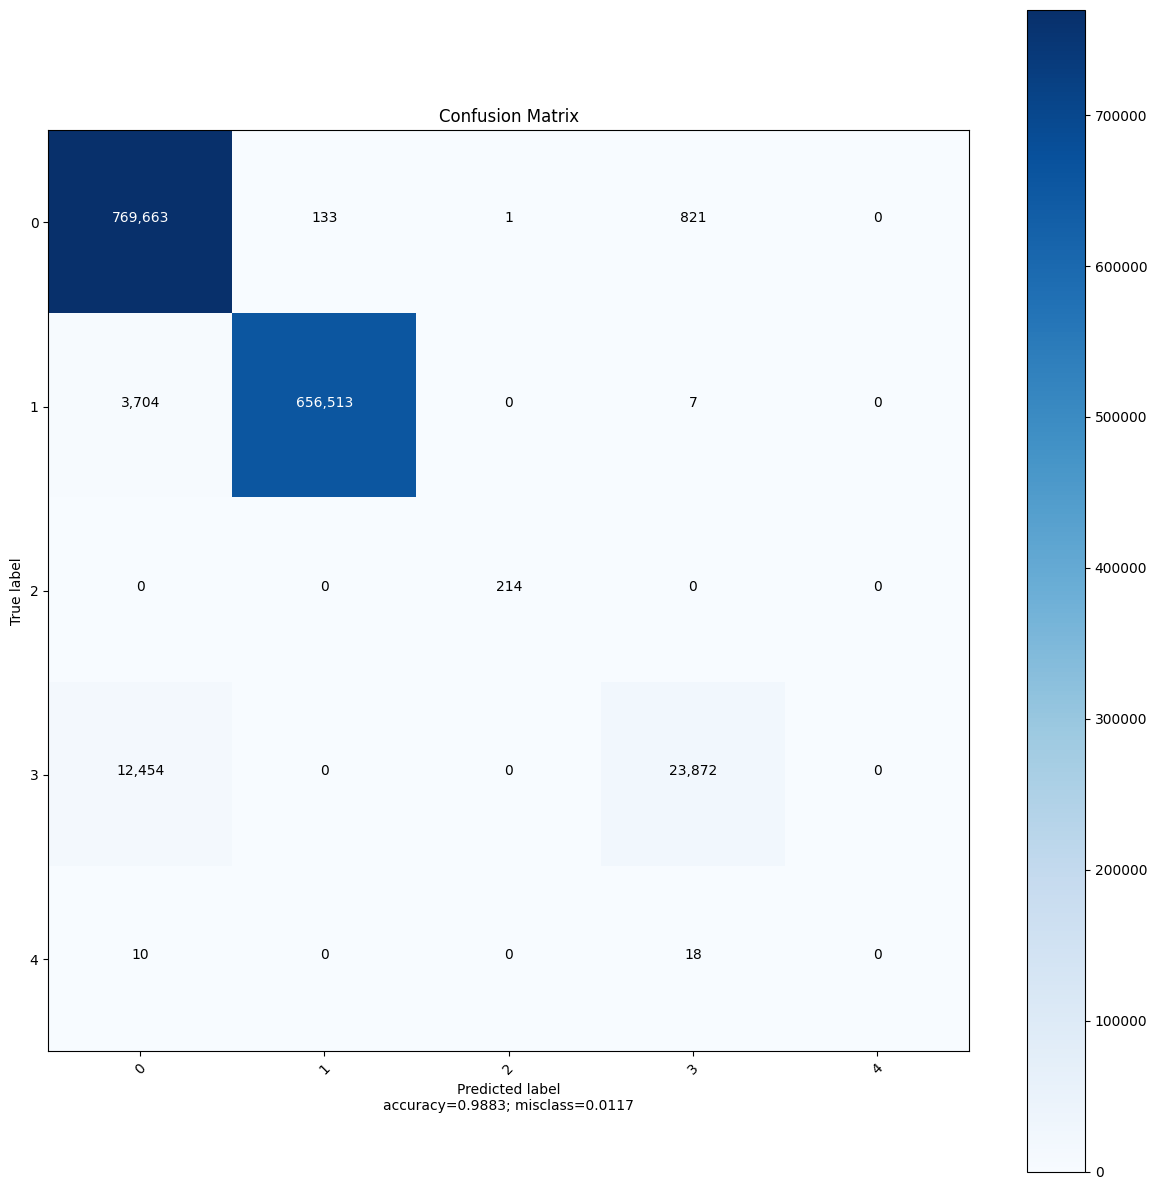

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0     0.9794    0.9988    0.9890    770618
           1     0.9998    0.9944    0.9971    660224
           2     0.9953    1.0000    0.9977       214
           3     0.9658    0.6572    0.7821     36326
           4     0.0000    0.0000    0.0000        28

    accuracy                         0.9883   1467410
   macro avg     0.7881    0.7301    0.7532   1467410
weighted avg     0.9882    0.9883    0.9875   1467410



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [14]:
import numpy as np
import pandas as pd

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


from sklearn.metrics import confusion_matrix

print("target_names",np.unique(actual))
plot_confusion_matrix(cm=confusion_matrix(actual, test_pred),
                      normalize=False,
                      target_names=np.unique(actual),
                      title="Confusion Matrix")

from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=4))
report = classification_report(actual, test_pred, digits=4, output_dict=True)
df = pd.DataFrame(report).transpose()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [ ]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [ ]:
#from dgl.data.utils import load_graphs   
#G = load_graphs("./data.bin")[0][0]

In [ ]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [ ]:
G = G.to_directed()

In [ ]:
G = from_networkx(G,edge_attrs=['h','label'])

In [ ]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [ ]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1]) 

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [ ]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [ ]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [ ]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
G.ndata['h'].shape

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [ ]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 6)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [ ]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(G.edata['label'].cpu().numpy()),
#                                                  G.edata['label'].cpu().numpy())

import numpy as np
from sklearn.utils import class_weight

y = G.edata['label'].cpu().numpy()
classes = np.unique(y)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

In [ ]:
class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [ ]:
G = G.to('cpu')

In [ ]:
G.device

In [ ]:
G.ndata['h'].device  

In [ ]:
G.edata['h'].device  

In [ ]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)

opt = th.optim.Adam(model.parameters())

for epoch in range(1,14500):
    pred = model(G, node_features,edge_features)
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    # if epoch % 100 == 0:
    print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

In [ ]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [ ]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), 55)

In [ ]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [ ]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [ ]:
G_test = G_test.to('cuda:0')

In [ ]:
th.cuda.empty_cache()

In [ ]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [ ]:
print(str(elapsed) + ' seconds')

In [ ]:
test_pred = test_pred.argmax(1)

In [ ]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [ ]:
edge_label = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(edge_label, test_pred), 
                      normalize    = False,
                      target_names = np.unique(edge_label),
                      title        = "Confusion Matrix")